# SITCOM-797

Here is what was requested:

To analyze the positioning system after a slew, create plots for the mirror

- decentering (X and Y)
- mirror tilt (RX, RY, RY)
- piston
- Create a histogram for each parameter for a configurable time period.

Include the limits in all plots:

* the mirror decenters at less than +/- 6 micrometer
* mirror tilt less than +/- 24 e-6 degree
* piston less than +/- 1 micrometer


### Prepare Notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy import time
from astropy import units as u
import matplotlib.dates as mdates

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

In [3]:
# Select data from a given date
#dayObs = 20230627
dayObs = 20230711
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

Found 37 slews and 0 tracks


In [4]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

In [5]:
pos_columns = [a + "Position" for a in "xyz"]
rot_columns = [a + "Rotation" for a in "xyz"]
all_columns = pos_columns + rot_columns

## Analysis

 * Loop over all the slews
 * Compute mean, sigma and maximum difference w.r.t. the first values
 * Store results in a dataframe in order to plot them later

In [6]:
# define small amount of time to check mirror position before and after the slews
delta_t = 1
dt_begin = time.TimeDelta(-delta_t, format='sec')
dt_end = time.TimeDelta(delta_t, format='sec')

results = pd.DataFrame(columns=["i_slew", "duration", "x_mean", "y_mean", "z_mean", "x_sigma", "y_sigma", "z_sigma", 
                                "R_x_mean", "R_y_mean", "R_z_mean", "Rx_sigma", "Ry_sigma", "Rz_sigma",
                                "dx_max", "dy_max", "dz_max", "R_dx_max", "R_dy_max", "R_dz_max",
                                "x_before", "y_before", "z_before", "R_x_before", "R_y_before", "R_z_before",
                                "x_after", "y_after", "z_after", "R_x_after", "R_y_after", "R_z_after",
                                "start_ele", "end_ele", "start_azi", "end_azi", "speed_ele", "slew_end"])


for i_slew, slew in enumerate(slews):
    #print(i_slew)
    # Get ims data
    df_ims = getEfdData(client, 'lsst.sal.MTM1M3.imsData', event=slew)
    if len(df_ims) == 0:
        print(f"No data for slew number: {i_slew}")
        continue 
        
    df_ims = df_ims[all_columns]

    # Convert meter to milimeter to make is easier to analyse
    df_ims[pos_columns] = df_ims[pos_columns] * 1e3
    
    # get ims data before and after the slew
    df_ims_before = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=slew.begin, timespan=dt_begin)
    if len(df_ims_before) == 0:
        print(f"No data before slew number: {i_slew}")
        continue 
    df_ims_before = df_ims_before[all_columns]
    df_ims_before[pos_columns] = df_ims_before[pos_columns]*u.m.to(u.mm)
    
    df_ims_after = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=slew.end, timespan=dt_end)
    if len(df_ims_before) == 0:
        print(f"No data after slew number: {i_slew}")
        continue 
    df_ims_after = df_ims_after[all_columns]
    df_ims_after[pos_columns] = df_ims_after[pos_columns]*u.m.to(u.mm)
    
    mean = {}
    sigma = {}
    max_diff = {}
    mean_before={}
    mean_after = {}
    for col in all_columns:
        mean[col] = np.mean(df_ims[col])
        sigma[col] = np.std(df_ims[col])
        t0 = df_ims.index[0]
        max_diff[col] = np.max(np.abs(df_ims[t0:t0][col][0]-df_ims[col]))
        
        mean_before[col] = np.mean(df_ims_before[col])
        mean_after[col] = np.mean(df_ims_after[col])
        
    # get elevation data
    df_ele = getEfdData(client, 'lsst.sal.MTMount.elevation', event= slew)
    pos_ele = df_ele["actualPosition"]
    start_ele = pos_ele[pos_ele.index[0]]
    end_ele = pos_ele[pos_ele.index[len(pos_ele)-1]]
    # get speed
    speed_ele = np.mean(df_ele["demandVelocity"])
    
    # get azimuth data
    df_azi = getEfdData(client, 'lsst.sal.MTMount.azimuth', event= slew)
    pos_azi = df_azi["actualPosition"]
    start_azi = pos_azi[pos_azi.index[0]]
    end_azi = pos_azi[pos_azi.index[len(pos_azi)-1]]
        
    # Store computed values in dataframe
    vect = [[i_slew], [slew.duration], [mean[i] for i in pos_columns], [sigma[i] for i in pos_columns], [mean[i] for i in rot_columns], [sigma[i] for i in rot_columns],
            [max_diff[i] for i in pos_columns], [max_diff[i] for i in rot_columns],
            [mean_before[i] for i in pos_columns], [mean_before[i] for i in rot_columns], [mean_after[i] for i in pos_columns], [mean_after[i] for i in rot_columns],
            [start_ele], [end_ele], [start_azi], [end_azi], [speed_ele], [slew.end]]
    flat_vect = [item for sublist in vect for item in sublist]
    results = pd.concat([results, pd.DataFrame([flat_vect], columns=results.columns)], ignore_index=True)
        

In [44]:
results

,i_slew,duration,x_mean,y_mean,z_mean,x_sigma,y_sigma,z_sigma,R_x_mean,R_y_mean,...,z_after,R_x_after,R_y_after,R_z_after,start_ele,end_ele,start_azi,end_azi,speed_ele,slew_end
0,0,10.529821,-1.467891,5.573259,-1.090555,0.000122,0.000070,0.000050,-0.002689,-0.014370,...,-1.090561,-0.002690,-0.014370,0.008361,89.857499,89.857499,152.960205,151.974922,0.000000e+00,1689098593.3483126
1,1,18.661617,-1.467867,5.571195,-1.090376,0.000125,0.000534,0.000140,-0.002692,-0.014373,...,-1.090230,-0.002678,-0.014373,0.008348,89.857500,88.054417,151.942485,151.942484,-9.738160e-02,1689098616.7710545
2,2,9.975383,-1.467728,5.571993,-1.089816,0.000047,0.000105,0.000038,-0.002680,-0.014369,...,-1.089875,-0.002682,-0.014369,0.008357,88.020001,88.020000,151.924107,150.992820,0.000000e+00,1689098881.6797037
3,3,18.696425,-1.467638,5.570002,-1.089654,0.000123,0.000548,0.000082,-0.002682,-0.014374,...,-1.089556,-0.002669,-0.014372,0.008344,88.020000,86.215425,150.952580,150.952579,-9.757140e-02,1689098905.1366441
4,4,171.711508,-1.467674,5.553286,-1.095379,0.000319,0.007948,0.006304,-0.002680,-0.014374,...,-1.110488,-0.002746,-0.014346,0.008277,86.218937,43.550930,150.952579,150.952580,-2.489274e-01,1689099153.0145297
5,5,1.575718,-1.466950,5.540833,-1.111192,0.000000,0.000000,0.000000,-0.002748,-0.014337,...,-1.111192,-0.002748,-0.014337,0.008284,43.277486,43.277486,150.952771,150.952771,0.000000e+00,1689099429.7679937
6,6,593.724419,-1.466633,5.539362,-1.109878,0.000292,0.000790,0.000598,-0.002748,-0.014332,...,-1.109055,-0.002744,-0.014329,0.008287,43.277486,43.349999,150.952771,150.940308,0.000000e+00,1689100029.9288
7,7,1.589343,-1.466153,5.537577,-1.108593,0.000090,0.000001,0.000053,-0.002742,-0.014327,...,-1.108593,-0.002742,-0.014327,0.008286,43.350564,43.350564,150.940489,150.940489,0.000000e+00,1689100140.8258526
8,8,91.596498,-1.465987,5.537839,-1.108578,0.000139,0.000569,0.000266,-0.002742,-0.014324,...,-1.107300,-0.002738,-0.014322,0.008290,43.350564,45.093376,150.940489,149.895253,1.863502e-02,1689100252.9320147
9,9,180.886136,-1.464792,5.554434,-1.092122,0.000422,0.008747,0.007174,-0.002633,-0.014327,...,-1.084615,-0.002666,-0.014339,0.008362,45.111450,89.948520,149.895253,149.895253,2.479692e-01,1689100884.1079


Found 0 outliers xPosition (limit: 100 microns)
Found 9 outliers xRotation (limit: 0.55 arcsec)
Found 0 outliers yPosition (limit: 100 microns)
Found 0 outliers yRotation (limit: 0.55 arcsec)
Found 0 outliers zPosition (limit: 100 microns)
Found 5 outliers zRotation (limit: 0.55 arcsec)


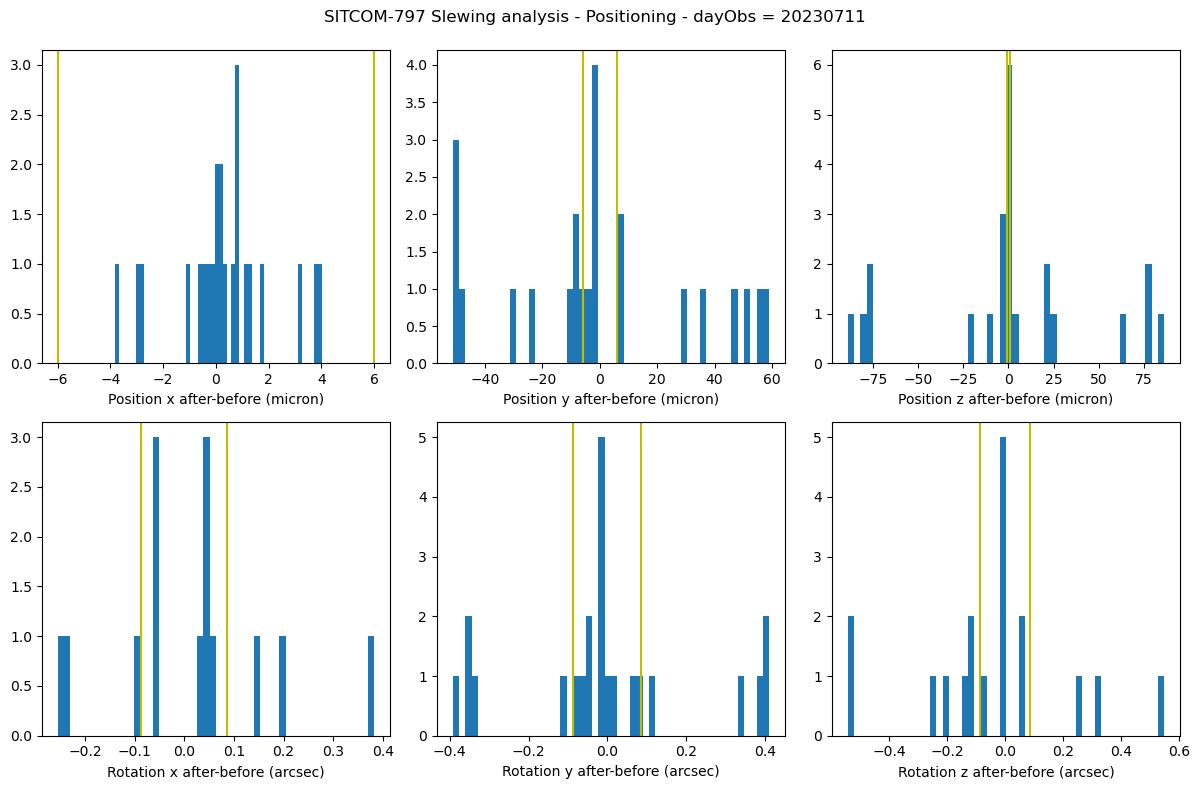

In [7]:
# Plot results (histograms)
%matplotlib inline

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

axes = "xyz"

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55 

title = f"SITCOM-797 Slewing analysis - Positioning - dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(12, 8))

# Check whether the TMA actually move in elevation
mask_move = abs(results["speed_ele"]) > 0.05

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"])*u.mm.to(u.micron)
    mask_out = np.abs(diff) < out_limit_pos
    print(f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Position (limit: {out_limit_pos} microns)")
    mask = mask_out & mask_move
    axs[0][i].hist(diff[mask], bins=50)
    axs[0][i].set_xlabel(f"Position {axes[i]} after-before (micron)")
    
    R_diff = (results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"])*u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Rotation (limit: {out_limit_rot} arcsec)")
    mask = mask_out & mask_move
    axs[1][i].hist(R_diff[mask], bins=50)
    axs[1][i].set_xlabel(f"Rotation {axes[i]} after-before (arcsec)")
    
    if axes[i] in ["x", "y"]:
        axs[0][i].axvline(6, color='y')
        axs[0][i].axvline(-6, color='y')
        axs[1][i].axvline(0.0864, color='y')
        axs[1][i].axvline(-0.0864, color='y')
    else:
        axs[0][i].axvline(1, color='y')
        axs[0][i].axvline(-1, color='y')
        axs[1][i].axvline(0.0864, color='y')
        axs[1][i].axvline(-0.0864, color='y')
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.93)

Found 0 outliers xPosition (limit: 100 microns)
Found 9 outliers xRotation (limit: 0.55 arcsec)
Found 0 outliers yPosition (limit: 100 microns)
Found 0 outliers yRotation (limit: 0.55 arcsec)
Found 0 outliers zPosition (limit: 100 microns)
Found 5 outliers zRotation (limit: 0.55 arcsec)


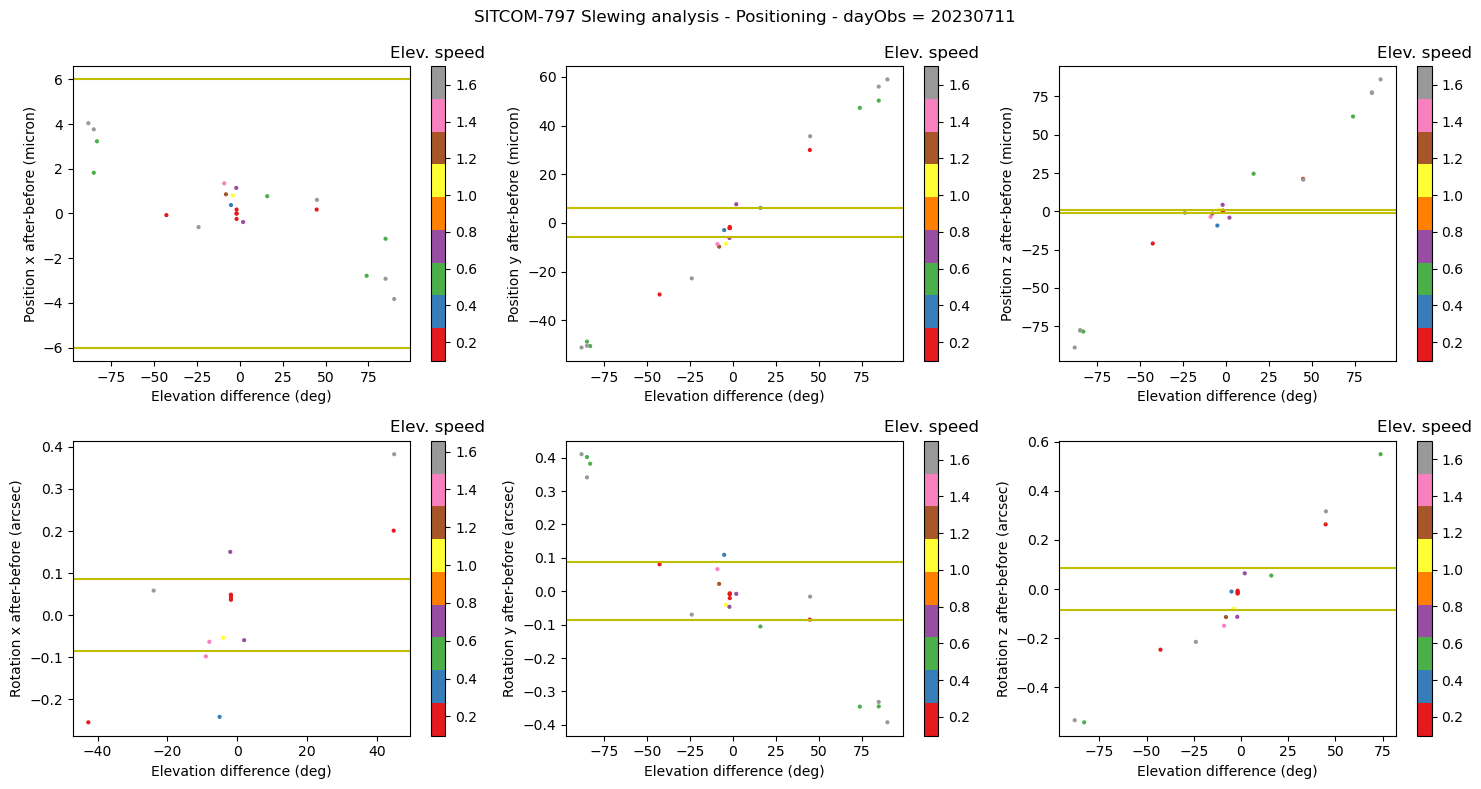

In [8]:
# Plot results (scatter plots)
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('Set1')

axes = [ "x", "y", "z"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55

title = f"SITCOM-797 Slewing analysis - Positioning - dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in elevation
#mask_move = abs(results["end_ele"] - results["start_ele"]) > 1
mask_move = abs(results["speed_ele"]) > 0.05

diff_ele = results["end_ele"] - results["start_ele"]

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"])*u.mm.to(u.micron)
    mask_out = np.abs(diff) < out_limit_pos
    print(f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Position (limit: {out_limit_pos} microns)")
    mask = mask_out & mask_move
    im = axs[0][i].scatter(diff_ele[mask], diff[mask], c=abs(results["speed_ele"][mask]), s=4, cmap=cm)
    axs[0][i].set_xlabel("Elevation difference (deg)")
    axs[0][i].set_ylabel(f"Position {axes[i]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title('Elev. speed')

    R_diff = (results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"])*u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Rotation (limit: {out_limit_rot} arcsec)")
    mask = mask_out & mask_move
    im = axs[1][i].scatter(diff_ele[mask], R_diff[mask], c=abs(results["speed_ele"][mask]), s=4, cmap=cm)
    axs[1][i].set_xlabel("Elevation difference (deg)")
    axs[1][i].set_ylabel(f"Rotation {axes[i]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title('Elev. speed')
    
    if axes[i] in ["x", "y"]:
        axs[0][i].axhline(6, color='y')
        axs[0][i].axhline(-6, color='y')
        axs[1][i].axhline(0.0864, color='y')
        axs[1][i].axhline(-0.0864, color='y')
    else:
        axs[0][i].axhline(1, color='y')
        axs[0][i].axhline(-1, color='y')
        axs[1][i].axhline(0.0864, color='y')
        axs[1][i].axhline(-0.0864, color='y')
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

Found 0 outliers for pair xy (limit: 100 microns)
Found 9 outliers for pair xy (limit: 0.55 arcsec)
Found 0 outliers for pair yz (limit: 100 microns)
Found 5 outliers for pair yz (limit: 0.55 arcsec)
Found 0 outliers for pair xz (limit: 100 microns)
Found 9 outliers for pair xz (limit: 0.55 arcsec)


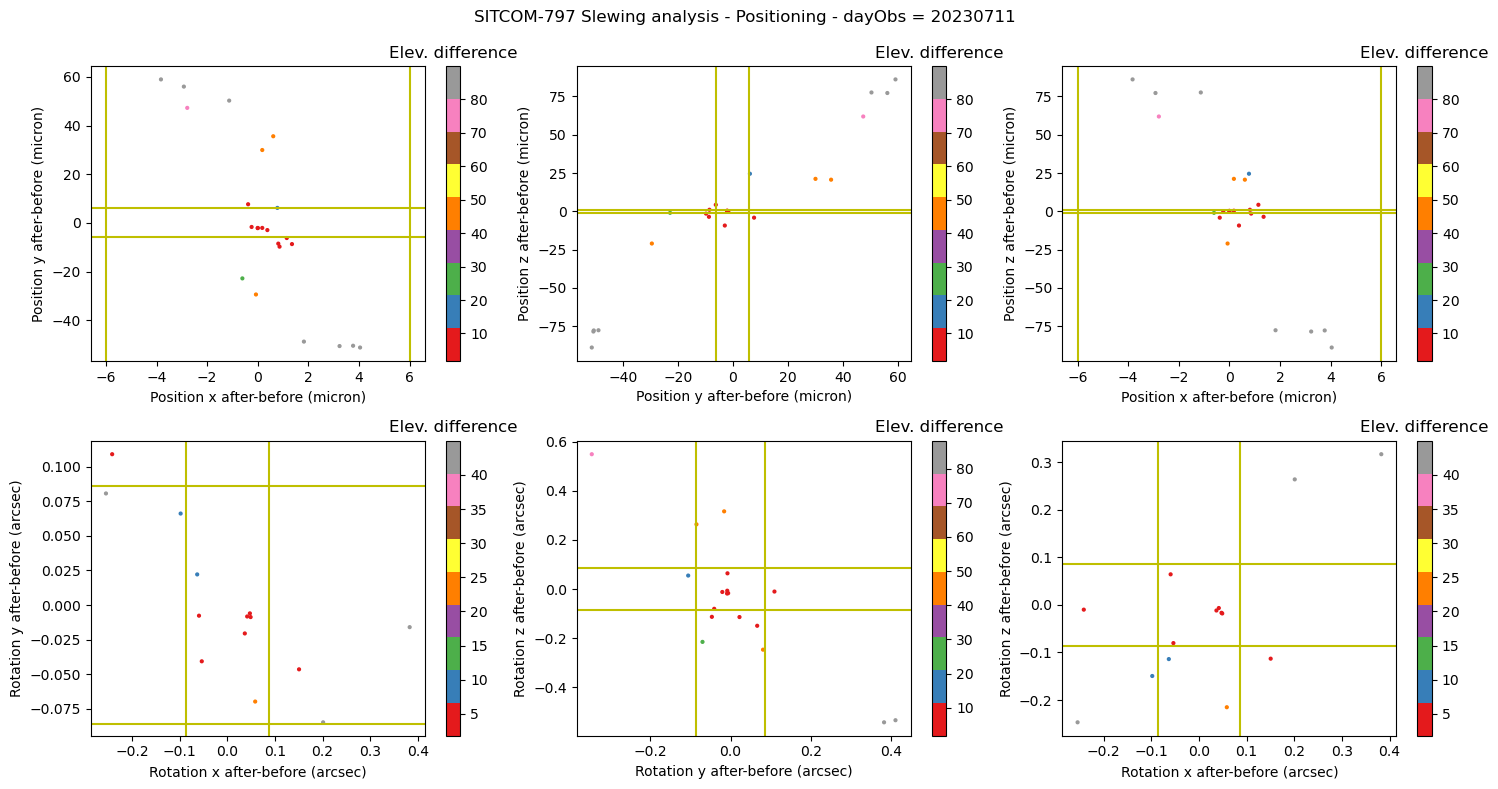

In [9]:
# Plot results (scatter plots)
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('Set1')

pairs = [ "xy", "yz", "xz"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55

title = f"SITCOM-797 Slewing analysis - Positioning - dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in elevation
mask_move = abs(results["speed_ele"]) > 0.05

# Elevation change
diff_ele = results["end_ele"] - results["start_ele"]

for i in range(3):
    pair = pairs[i]
    
    # Positions
    diff_1 = (results[f"{pair[0]}_after"] - results[f"{pair[0]}_before"])*u.mm.to(u.micron)
    diff_2 = (results[f"{pair[1]}_after"] - results[f"{pair[1]}_before"])*u.mm.to(u.micron)
    mask_out = (np.abs(diff_1) < out_limit_pos) & (np.abs(diff_2) < out_limit_pos)
    print(f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_pos} microns)")
    mask = mask_out & mask_move
    im = axs[0][i].scatter(diff_1[mask], diff_2[mask], c=abs(diff_ele[mask]), s=4, cmap=cm)
    axs[0][i].set_xlabel(f"Position {pair[0]} after-before (micron)")
    axs[0][i].set_ylabel(f"Position {pair[1]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title('Elev. difference')
    
    if pair[0] == 'x' or pair[0] == 'y':
        axs[0][i].axvline(6, color='y')
        axs[0][i].axvline(-6, color='y')
    else:
        axs[0][i].axvline(1, color='y')
        axs[0][i].axvline(-1, color='y')
        
    if pair[1] == 'x' or pair[1] == 'y':
        axs[0][i].axhline(6, color='y')
        axs[0][i].axhline(-6, color='y')
    else:
        axs[0][i].axhline(1, color='y')
        axs[0][i].axhline(-1, color='y')
    
    # Rotations
    R_diff_1 = (results[f"R_{pair[0]}_after"] - results[f"R_{pair[0]}_before"])*u.degree.to(u.arcsec)
    R_diff_2 = (results[f"R_{pair[1]}_after"] - results[f"R_{pair[1]}_before"])*u.degree.to(u.arcsec)
    mask_out = (np.abs(R_diff_1) < out_limit_rot) & (np.abs(R_diff_2) < out_limit_rot)
    print(f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_rot} arcsec)")
    mask = mask_out & mask_move
    im = axs[1][i].scatter(R_diff_1[mask], R_diff_2[mask], c=abs(diff_ele[mask]), s=4, cmap=cm)
    axs[1][i].set_xlabel(f"Rotation {pair[0]} after-before (arcsec)")
    axs[1][i].set_ylabel(f"Rotation {pair[1]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title('Elev. difference')
    
    axs[1][i].axhline(0.0864, color='y')
    axs[1][i].axhline(-0.0864, color='y')
    axs[1][i].axvline(0.0864, color='y')
    axs[1][i].axvline(-0.0864, color='y')
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

## Now we select one specific large amplitude slew in order to analyse the variation of the positions / rotations as a function of time 

In [78]:
# Find the slew where the elevation difference is maximum
ele_index = np.argmax(diff_ele)
ele_index=19
print("Elevation difference of slew %i: %.1f degrees"%(ele_index, diff_ele[ele_index]))
print("Start elevattion is %.1f degrees - End elevation is %.1f degrees"%(results["start_ele"][ele_index], results["end_ele"][ele_index]))

Elevation difference of slew 19: -88.1 degrees
Start elevattion is 88.1 degrees - End elevation is -0.0 degrees


In [79]:
# Get ims data covering the selected slew plus some extra time before and after the slew
delta_t = 40
dt_end = time.TimeDelta(delta_t, format='sec')
dt_begin = time.TimeDelta(delta_t, format='sec')
df_ims = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=slews[ele_index].begin-dt_begin, end=slews[ele_index].end+dt_end)

# We also retreive the data correesponding to the exact slew duration in order to be able to find the start and the end of the slew
df_ims_slew = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=slews[ele_index].begin, end=slews[ele_index].end)

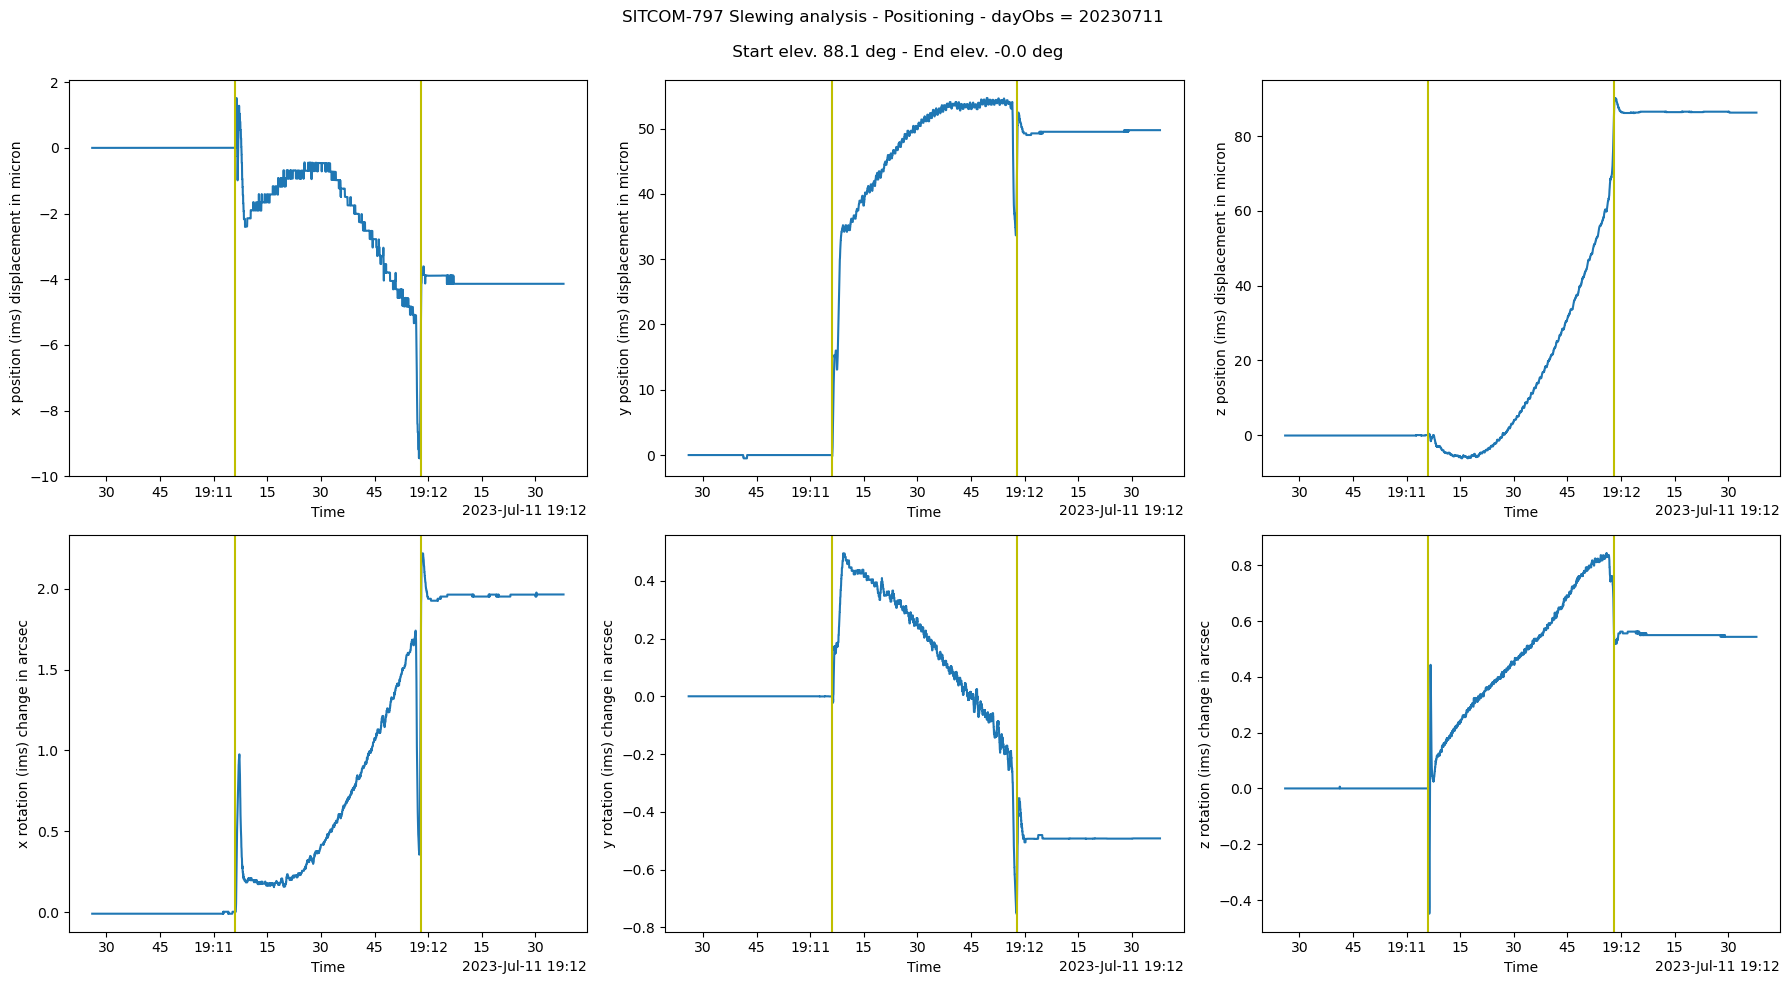

In [80]:
# Plot positions and rotation versus time

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

title = "SITCOM-797 Slewing analysis - Positioning - dayObs = %s \n\n Start elev. %.1f deg - End elev. %.1f deg"%(dayObs, results['start_ele'][ele_index], results['end_ele'][ele_index])
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(18, 10))

axes = "xyz"
for i in range(3):
    axis = axes[i]
    
    # Positions
    _ = axs[0][i].plot(df_ims.index, (results[f"{axis}_before"][ele_index]-df_ims[f"{axis}Position"]*u.m.to(u.mm))*u.mm.to(u.micron))
    axs[0][i].axvline(df_ims_slew.index[0], c="y")
    axs[0][i].axvline(df_ims_slew.index[-1], c="y")
    axs[0][i].set_xlabel("Time")
    axs[0][i].set_ylabel(f"{axis} position (ims) displacement in micron")
    axs[0][i].xaxis.set_major_formatter(formatter)
    
    # Rotations
    _ = axs[1][i].plot(df_ims.index, (results[f"R_{axis}_before"][ele_index]-df_ims[f"{axis}Rotation"])*u.degree.to(u.arcsec))
    axs[1][i].axvline(df_ims_slew.index[0], c="y")
    axs[1][i].axvline(df_ims_slew.index[-1], c="y")
    axs[1][i].set_xlabel("Time")
    axs[1][i].set_ylabel(f"{axis} rotation (ims) change in arcsec")
    axs[1][i].xaxis.set_major_formatter(formatter)
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

In [52]:
results["R_x_before"][3]*3600

-9.643222857266665

In [53]:
results["R_x_after"][3]*3600

-9.607804900534997

In [28]:
print(slews[14].end, slews[15].begin, slews[15].beginFloat-slews[14].endFloat)

1689101866.7749848 1689101919.9321063 53.157121419906616


In [27]:
slews[14]

dayObs: 20230711
seqNum: 14
type: SLEWING
endReason: STOPPED
duration: 149.34468293190002
begin: <Time object: scale='tai' format='unix_tai' value=1689101717.430302>,
end: <Time object: scale='tai' format='unix_tai' value=1689101866.7749848>
beginFloat: 1689101717.430302
endFloat: 1689101866.7749848


In [45]:
df_ims["private_efdStamp"]

2023-07-11 18:53:40.445951+00:00    1.689102e+09
2023-07-11 18:53:40.466020+00:00    1.689102e+09
2023-07-11 18:53:40.486052+00:00    1.689102e+09
2023-07-11 18:53:40.506017+00:00    1.689102e+09
2023-07-11 18:53:40.526015+00:00    1.689102e+09
                                        ...     
2023-07-11 18:58:09.669213+00:00    1.689102e+09
2023-07-11 18:58:09.689208+00:00    1.689102e+09
2023-07-11 18:58:09.729195+00:00    1.689102e+09
2023-07-11 18:58:09.749238+00:00    1.689102e+09
2023-07-11 18:58:09.769204+00:00    1.689102e+09
Name: private_efdStamp, Length: 11120, dtype: float64

In [49]:
len(df_ims)

11120

In [68]:
(df_ims["private_efdStamp"]-slews[14].endFloat).abs().argsort()[0]

10169

In [67]:
(df_ims["private_efdStamp"]-slews[14].endFloat).abs()[4003]

149.34740495681763

In [66]:
(df_ims["private_efdStamp"]-slews[14].beginFloat).abs()[4004]

0.017255783081054688

In [75]:
df_ims = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=slews[14].begin, end=slews[14].begin)

In [74]:
df_ims

,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,rawSensorData0,rawSensorData1,...,rawSensorData5,rawSensorData6,rawSensorData7,timestamp,xPosition,xRotation,yPosition,yRotation,zPosition,zRotation
2023-07-11 18:54:40.465540+00:00,1.689102e+09,MTM1M3,1.689102e+09,8712,1.689102e+09,a253ecac,7058773,1.689102e+09,30.894501,24.6595,...,25.318501,27.219000,23.6710,1.689102e+09,-0.001461,-0.002999,0.005518,-0.014231,-0.001145,0.008216
2023-07-11 18:54:40.485609+00:00,1.689102e+09,MTM1M3,1.689102e+09,8712,1.689102e+09,a253ecac,7058774,1.689102e+09,30.894501,24.6595,...,25.318501,27.219000,23.6710,1.689102e+09,-0.001461,-0.002999,0.005518,-0.014231,-0.001145,0.008216
2023-07-11 18:54:40.505537+00:00,1.689102e+09,MTM1M3,1.689102e+09,8712,1.689102e+09,a253ecac,7058775,1.689102e+09,30.894501,24.6595,...,25.318501,27.219000,23.6710,1.689102e+09,-0.001461,-0.002999,0.005518,-0.014231,-0.001145,0.008216
2023-07-11 18:54:40.525558+00:00,1.689102e+09,MTM1M3,1.689102e+09,8712,1.689102e+09,a253ecac,7058776,1.689102e+09,30.894501,24.6595,...,25.318501,27.219000,23.6710,1.689102e+09,-0.001461,-0.002999,0.005518,-0.014231,-0.001145,0.008216
2023-07-11 18:54:40.545595+00:00,1.689102e+09,MTM1M3,1.689102e+09,8712,1.689102e+09,a253ecac,7058777,1.689102e+09,30.894501,24.6595,...,25.318501,27.219000,23.6710,1.689102e+09,-0.001461,-0.002999,0.005518,-0.014231,-0.001145,0.008216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-11 18:57:09.689079+00:00,1.689102e+09,MTM1M3,1.689102e+09,8712,1.689102e+09,a253ecac,7064934,1.689102e+09,30.934000,24.6425,...,25.329500,27.313999,23.7120,1.689102e+09,-0.001464,-0.002701,0.005567,-0.014322,-0.001083,0.008372
2023-07-11 18:57:09.709087+00:00,1.689102e+09,MTM1M3,1.689102e+09,8712,1.689102e+09,a253ecac,7064935,1.689102e+09,30.934000,24.6425,...,25.329500,27.313999,23.7120,1.689102e+09,-0.001464,-0.002701,0.005567,-0.014322,-0.001083,0.008372
2023-07-11 18:57:09.729083+00:00,1.689102e+09,MTM1M3,1.689102e+09,8712,1.689102e+09,a253ecac,7064936,1.689102e+09,30.934000,24.6425,...,25.329500,27.313999,23.7125,1.689102e+09,-0.001464,-0.002698,0.005568,-0.014322,-0.001084,0.008370
2023-07-11 18:57:09.749077+00:00,1.689102e+09,MTM1M3,1.689102e+09,8712,1.689102e+09,a253ecac,7064937,1.689102e+09,30.934500,24.6425,...,25.329500,27.313999,23.7125,1.689102e+09,-0.001464,-0.002695,0.005568,-0.014322,-0.001083,0.008372


In [78]:
df_ims_2.index[-1]

Timestamp('2023-07-11 18:57:09.769093+0000', tz='UTC')